# Ronchi grating frames analysis of ADC effects

In [2517]:
import matplotlib.pyplot as plt  
import pandas as pd  
import os
import numpy as np
from astropy.io import fits 

from PIL import Image


#conda install -c astropy photutils

from photutils import centroid_com, centroid_1dg, centroid_2dg

#need to install newer version of scipy from conda, need 1.2 or newer for find_peaks function

from scipy.signal import find_peaks

#for animations
from matplotlib import animation, rc
from IPython.display import HTML

#patches
from matplotlib import patches as patches


from astropy.modeling import models, fitting

#from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

from astropy.modeling.models import custom_model

from scipy.optimize import curve_fit

In [2518]:
#@custom_model
def gauss_offset(x, amplitude=1., mean=0., stddev=1., H=0.):
    
    return H + amplitude * np.exp(-(x - mean) ** 2 / (2 * stddev ** 2))

def gauss_fit(H,x, y):
    mean = sum(x * y) / sum(y)
    stddev = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss_offset, x, y, p0=[H,max(y), mean, stddev])
    return popt

## import our fits file

In [2519]:
#filename="gf-cam.20191113.210243"
#filename="gf-cam.20191217.083513"
filename="gf-cam.20191106.205946"

#infocus
#im = fits.open("19sep30176-9-stack-darksub.fits")
#im = fits.open("gf-cam.20191217.083513.fits")
im = fits.open(filename + ".fits")
imarray0=im[0].data

### peek at the image array

In [2520]:
print(imarray0)

[[458 476 416 ... 481 536 494]
 [457 411 475 ... 530 488 507]
 [466 472 465 ... 551 523 478]
 ...
 [421 414 441 ... 563 490 441]
 [438 401 422 ... 566 533 512]
 [453 439 437 ... 436 477 465]]


### preview the image

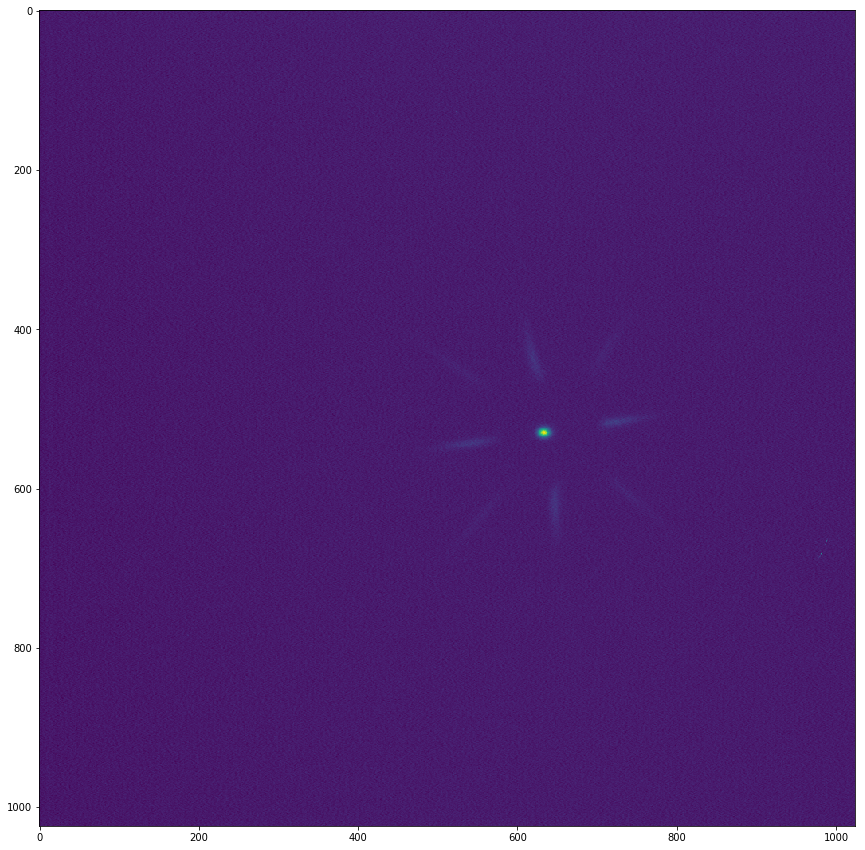

In [2521]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
#ax.imshow(imarray,origin='lower')
ax.imshow(imarray0)

#rect=plt.Rectangle((0, 0), 1, 1, color='r')
# Create a Rectangle patch
#rect = patches.Rectangle(xorigin,xwidth,yheight,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
#ax.add_patch(rect)

In [2522]:
#imarray=imarray[250:750,250:750]
#imarray=imarray0[300:800,400:900]

#fig,ax = plt.subplots()

#fig.set_size_inches(20, 15)
#ax.imshow(imarray,origin='lower')
#ax.imshow(imarray)

### Centroid the whole image

In [2543]:
cx, cy = centroid_com(imarray0)
print((cx,cy ))   

#if it fails, use max method
csumx=imarray0.sum(axis=0)
csumy=imarray0.sum(axis=1)

cx=(np.argmax(csumx))
cy=(np.argmax(csumy))
print(cx,cy)

(516.0050286456403, 508.88285892442394)
631 529


In [2544]:
hafbox=40

bigbox=250

imarray=imarray0[int(cy)-bigbox:int(cy)+bigbox,int(cx)-bigbox:int(cx)+bigbox]

cx, cy = centroid_com(imarray)

stellarbox=imarray[int(cy)-hafbox:int(cy)+hafbox,int(cx)-hafbox:int(cx)+hafbox]
#stellarbox=imarray[0:495,int(cy)-hafbox:int(cy)+hafbox]

#xmean=stellarbox.sum(axis=0)
#ymean=stellarbox.sum(axis=1)



#csx=(np.argmax(xmean))
#csy=(np.argmax(ymean))


#csx=np.argmax(stellarbox,axis=0)
#csy=np.argmax(stellarbox,axis=1)

#sx = cx-hafbox+csx
#sy = cy-hafbox+csy
#print(sx,sy)

#print(sx)
#print(sy)


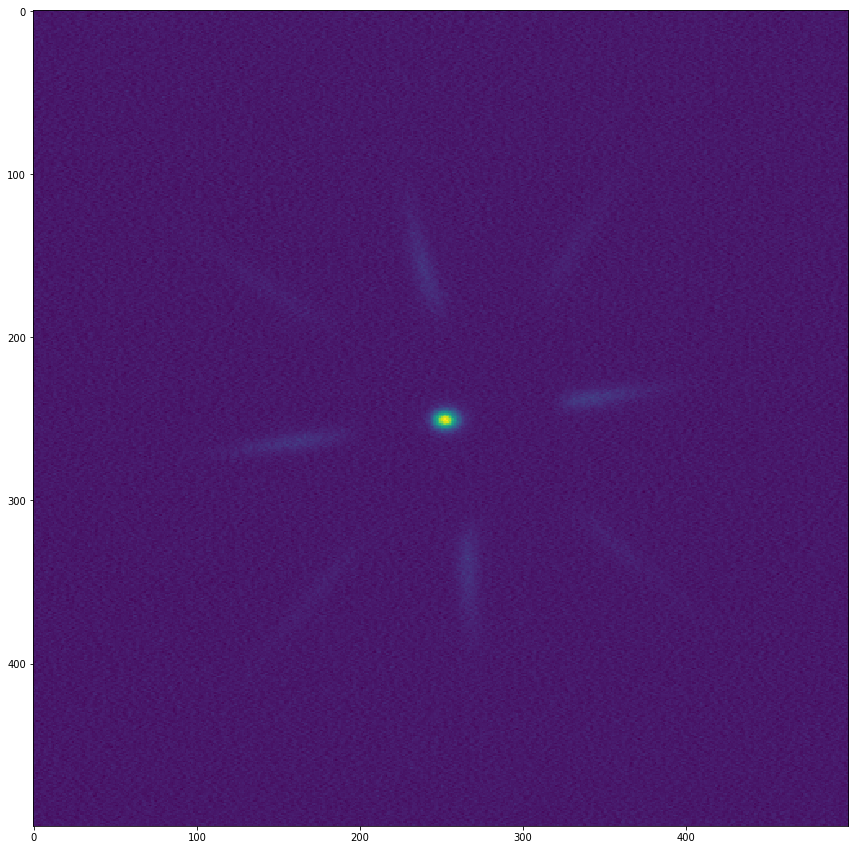

In [2545]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(imarray,origin='lower')
ax.imshow(imarray)

(79.5, -0.5)

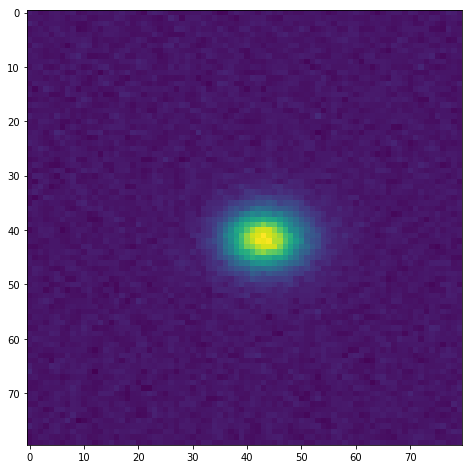

In [2546]:
fig,ax = plt.subplots()

fig.set_size_inches(8, 8)
ax.imshow(stellarbox,origin='lower')

ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1]) 


In [2548]:
#print(xmean)

xsum=stellarbox.sum(axis=0)
ysum=stellarbox.sum(axis=1)


data=xsum
y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
x=np.arange(80)
H, A, x0, stddev = gauss_fit(0.1,x, y)
print(H)
print(A)
print(x0)
print(stddev)
csx=A

data=ysum
y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
x=np.arange(80)
H, A, x0, stddev = gauss_fit(0.1,x, y)
print(H)
print(A)
print(x0)
print(stddev)
csy=A

sx = cx-hafbox+csx
sy = cy-hafbox+csy

0.9251385817485196
43.20687637677153
-5.219248787540409
0.06170360062634445
0.9660018307865291
41.594078295249155
-3.87769414877976
0.02507357508475356


### plot the centroid coordinates

(499.5, -0.5)

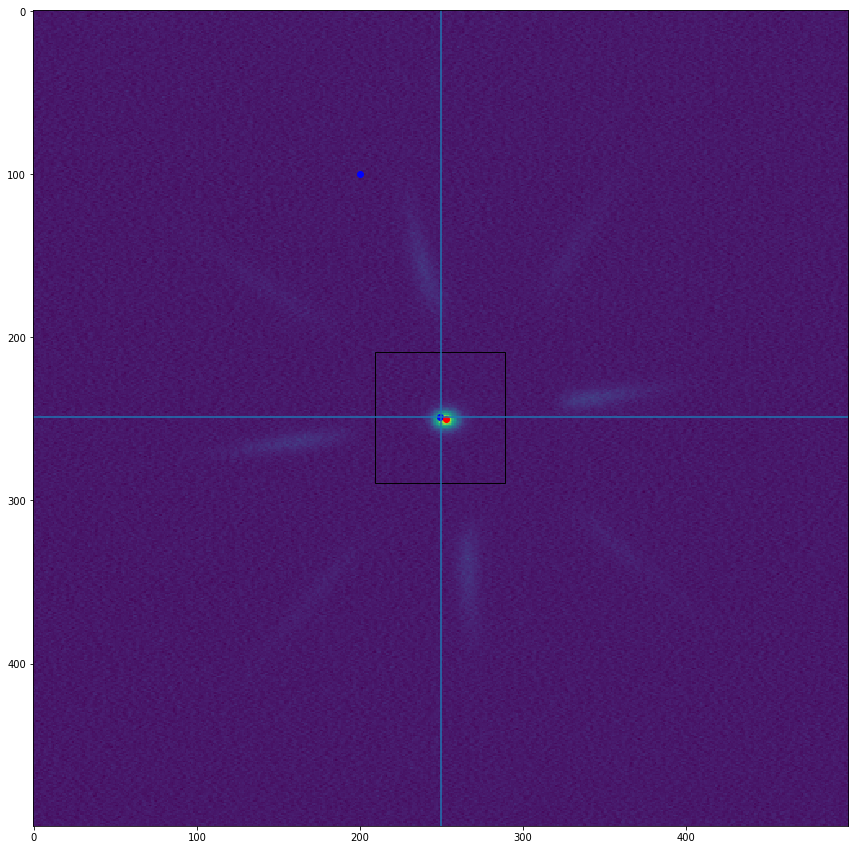

In [2549]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(imarray,origin='lower')


ax.plot(int(cx),int(cy), 'bo')

ax.plot(int(sx),int(sy), 'ro')

p = plt.Rectangle((int(cx)-hafbox, int(cy)-hafbox), 2*hafbox, 2*hafbox, fill=False)
#p = plt.Rectangle((200, 100), 2*hafbox, 2*hafbox, fill=False)
#p.set_transform(ax.transAxes)
#p.set_clip_on(False)
ax.add_patch(p)

ax.plot(200,100,'bo')
ax.axvline(cx)
ax.axhline(cy)

ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1]) 




### plot a 120x400 crop of the image

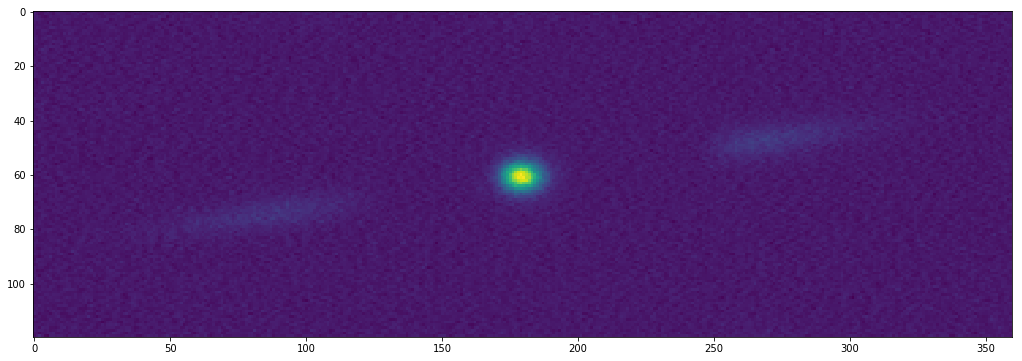

In [2550]:
bds=60
bdl=180

subim=imarray[int(sy)-bds:int(sy)+bds,int(sx)-bdl:int(sx)+bdl]

fig,ax = plt.subplots()

fig.set_size_inches(18, 6)
#ax.imshow(subim,origin='lower',cmap='gray')

ax.imshow(subim)

#ax.plot(int(cy),int(cx), 'bo')

In [2551]:
print(int(sy)-bds)
print(int(sy)+bds)
print(int(sx)-bdl)
print(int(sx)+bdl)

190
310
73
433


### populate an array max intensity values of each column

In [2552]:
hormax=np.amax(subim,axis=0)

print(hormax)


[ 558  540  597  580  542  556  566  548  530  569  554  544  551  549
  582  541  565  576  551  531  584  569  535  554  556  586  553  566
  554  557  548  541  574  545  596  587  558  580  559  572  557  552
  565  566  568  564  551  574  568  588  582  601  580  600  575  590
  591  613  615  604  653  597  561  601  624  654  627  629  650  632
  624  668  659  623  643  667  654  647  651  656  684  677  711  704
  685  653  643  689  712  702  712  678  670  711  653  649  653  683
  648  631  627  642  649  641  619  620  641  601  604  635  617  606
  620  630  585  569  620  580  562  562  582  545  562  578  560  586
  565  552  540  557  568  548  553  565  558  559  587  549  558  568
  553  583  547  574  563  581  574  559  534  555  568  549  567  568
  568  562  581  543  553  550  571  590  569  558  584  564  591  627
  672  753  829  962 1252 1403 1606 1841 2106 2287 2412 2459 2439 2297
 2186 1882 1703 1480 1304 1083  943  870  718  663  630  603  616  563
  557 

### populate an array with the index of the column pixel intensity max

In [2553]:
horargmax=np.argmax(subim,axis=0)

horargmax=horargmax.astype(float)

print(horargmax)

[ 82.  34. 119.  26.  33.  97.  90.   6.  65.  19.  89.  25. 102.  45.
  88. 116.  19.  36.  83. 106. 112. 108.  13.  39.  16.  12.  47.  81.
  95. 118. 115.  23.  92.  70.  78.  73. 107.  69.  55.  19.  72.  99.
  81.  81.  80.  29.   2.  55.  18.  82.  81.  78.  83.  72.  87.  79.
  80.  77.  73.  78.  77.  76. 100.  77.  76.  79.  77.  76.  79.  76.
  75.  76.  77.  78.  77.  76.  76.  77.  77.  77.  75.  75.  76.  76.
  74.  77.  75.  76.  76.  73.  73.  75.  75.  71.  74.  73.  73.  73.
  73.  73.  74.  71.  73.  71.  69.  77.  77.  73.  69.  71.  71.  70.
  70.  70.  70.  71.  67.  70.  71.  13.  77. 109.  65.  72.  89.  85.
  90.  20.  79.  12.  56.  92.  42.  76.  98.  19.  85. 109.  44.  33.
  84.  41.  41.  94.  93.  27.  35.  17.  48.  41.  32.  14.  57.  34.
  34.  41.  72.  80.   8.  92. 104.  46.  20.  65.  65.  65.  60.  60.
  61.  61.  61.  60.  60.  60.  59.  60.  60.  60.  61.  60.  61.  62.
  61.  61.  60.  61.  61.  62.  62.  60.  59.  61.  58.  58.  60.  60.
  53. 

In [2554]:
cols=2*bdl
rows=2*bds

In [2555]:
X = np.arange(cols)

### NaN out the columns with no data

In [2556]:
hornanargmax=np.copy(horargmax)
for i in X:
    if hormax[int(i)] < 650:
        hornanargmax[int(i)]=np.nan

In [2557]:
print(hornanargmax)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan 77. nan nan nan nan 79. nan nan 79. nan nan 76.
 77. nan nan 76. 76. nan 77. 77. 75. 75. 76. 76. 74. 77. nan 76. 76. 73.
 73. 75. 75. 71. 74. nan 73. 73. nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan 61. 61. 61. 60. 60. 60. 59. 60. 60. 60. 61. 60.
 61. 62. 61. 61. 60. 61. 61. 62. 62. 60. 59. 61. nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

## Plot the intensity max position of each column

Text(0.5,0,'Pixel Column')

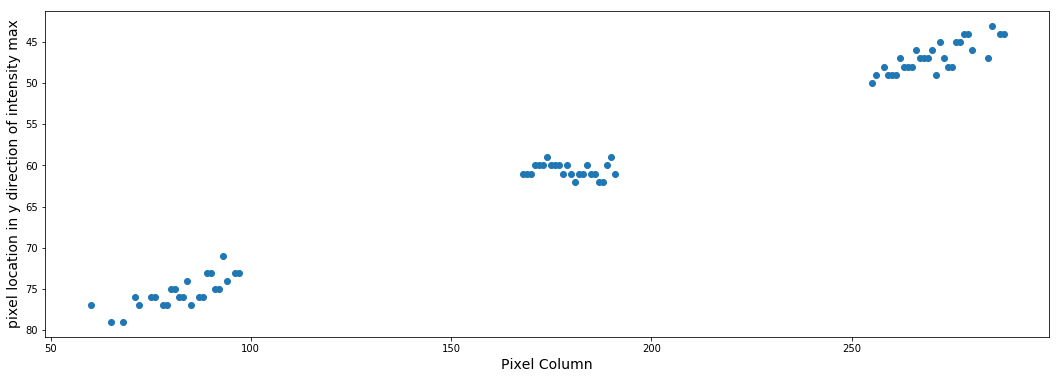

In [2558]:
fig,ax = plt.subplots()

fig.set_size_inches(18, 6)

ax.scatter(X,hornanargmax)
ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1]) 
ax.set_ylabel("pixel location in y direction of intensity max",size=14)
ax.set_xlabel("Pixel Column",size=14)
#plt.scatter(np.linspace(0,60,60),horargmax[60:120])

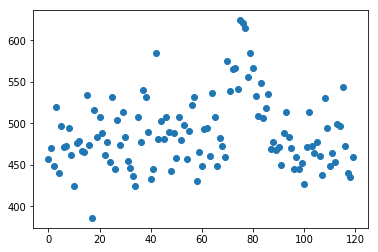

In [2559]:

data=subim[:,70]
y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
    
x=np.arange(rows)
plt.scatter(x,data)

In [2560]:

#w1r=(50,100)
#w2r=(270,330)

w1r=(70,90)
w2r=(260,290)



horwing1 = np.polyfit(X[w1r[0]:w1r[1]], horargmax[w1r[0]:w1r[1]], 1)
print(horwing1)

horwing2 = np.polyfit(X[w2r[0]:w2r[1]], horargmax[w2r[0]:w2r[1]], 1)
print(horwing2)

[-0.0924812  83.30225564]
[-0.1432703  85.59436411]


In [2561]:
#p1 = np.poly1d(horwing1)
#p2= np.poly1d(horwing2)

In [2562]:
#plt.figure(figsize=(20, 10))
#plt.scatter(X,hornanargmax)
#plt.plot(X[w1r[0]:w1r[1]],p1(X[w1r[0]:w1r[1]]),color='red')
#plt.text(100,65,'m = ' + str(round(horwing1[0],3)),fontsize=14,color='green')
#plt.plot(X[w2r[0]:w2r[1]],p2(X[w2r[0]:w2r[1]]),color='red')
#plt.text(300,35,'m = ' + str(round(horwing2[0],3)),fontsize=14,color='green')

In [2563]:
ghorwing1 = []

X1=range(w1r[0],w1r[1],1)

for i in X1:
    whichcol = i
    data=subim[:,whichcol]
    y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
    
    x=np.arange(rows)
    
    H, A, x0, stddev = gauss_fit(0.2,x, y)
    
    ghorwing1.append(A)
    
ghorwing1=np.array(ghorwing1)

ghorwing2 = []

X2=range(w2r[0],w2r[1],1)

for i in X2:
    whichcol = i
    data=subim[:,whichcol]
    y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
    
    x=np.arange(rows)
    
    H, A, x0, stddev = gauss_fit(0,x, y)
    
    ghorwing2.append(A)
    
ghorwing2=np.array(ghorwing2)



In [2564]:
print(ghorwing1)
#ghorwing2.shape

[76.40403651 76.10287104 76.73122121 75.23075639 75.59673846 76.40994878
 75.86312828 75.59247323 75.69346456 75.10298173 74.34359203 74.16608712
 74.65021574 74.59094991 74.31943619 74.48984311 74.60558184 75.27901679
 74.01474538 73.67060334]


In [2565]:
gaushwing1 = np.polyfit(X1, ghorwing1, 1)
gh1 = np.poly1d(gaushwing1)
gaushwing2 = np.polyfit(X2, ghorwing2, 1)
gh2 = np.poly1d(gaushwing2)

(78.35398182383405, 42.855602926370494)

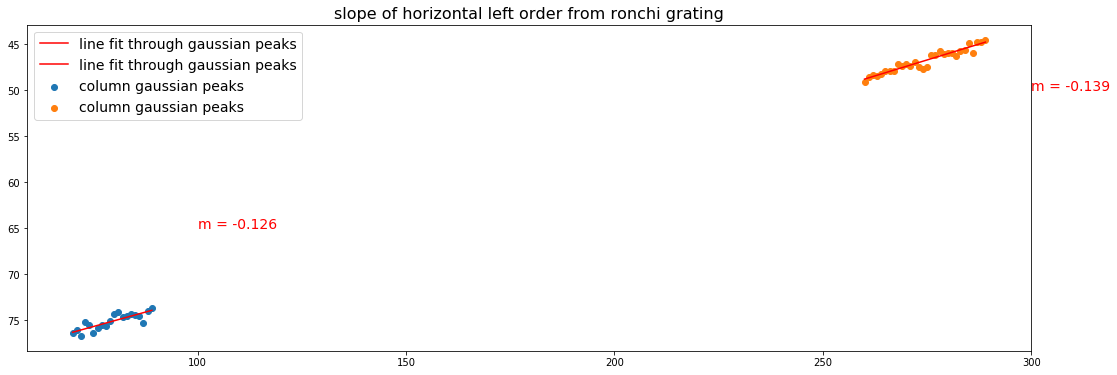

In [2566]:
m_hdiff=str(abs(round(gauswing2[0]-gauswing1[0],3)))

fig,ax = plt.subplots()

fig.set_size_inches(18, 6)

ax.scatter(X1,ghorwing1, label="column gaussian peaks")
ax.plot(X1,gh1(X1),color='red',label="line fit through gaussian peaks")
ax.scatter(X2,ghorwing2, label="column gaussian peaks")
ax.plot(X2,gh2(X2),color='red',label="line fit through gaussian peaks")
ax.text(100,65,'m = ' + str(round(gaushwing1[0],3)),fontsize=14,color='red')
ax.text(300,50,'m = ' + str(round(gaushwing2[0],3)),fontsize=14,color='red')
#ax.text(150,20,'diff between hor wings = ' + m_hdiff,fontsize=14,color='red')
ax.legend(fontsize=14)
ax.set_title("slope of horizontal left order from ronchi grating",fontsize=16)

ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1]) 


## work in the vertical direction

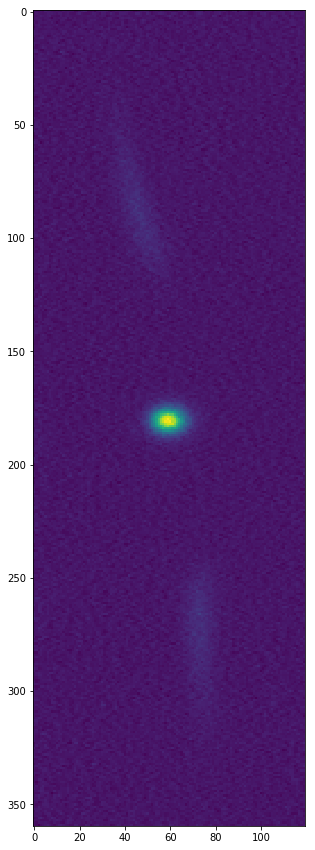

In [2567]:
subvim=imarray[int(sy)-bdl:int(sy)+bdl,int(sx)-bds:int(sx)+bds]

fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
#ax.imshow(subim,origin='lower',cmap='gray')

ax.imshow(subvim)

#ax.plot(int(cy),int(cx), 'bo')

In [2568]:
vermax=np.amax(subvim,axis=1)

print(vermax)


[ 561  561  569  532  559  531  566  556  555  556  565  540  565  561
  546  579  556  567  616  549  587  568  550  549  544  578  573  560
  560  582  552  567  570  578  561  541  592  565  557  550  579  568
  573  592  585  551  564  577  595  564  583  570  574  591  582  585
  615  570  574  575  609  611  588  585  559  600  656  604  610  598
  608  629  655  639  611  630  632  610  603  631  663  660  639  695
  682  659  683  713  671  690  681  674  671  652  703  633  659  660
  641  667  655  628  643  620  637  659  627  630  591  638  588  579
  603  581  629  580  573  576  571  582  544  569  572  549  564  543
  558  566  553  561  546  548  586  570  550  549  547  562  536  559
  569  564  575  554  548  562  551  581  567  577  564  547  568  568
  568  574  551  563  610  561  535  584  553  568  568  567  590  571
  589  590  588  645  697  801  930 1136 1371 1666 2053 2319 2459 2439
 2327 2099 1698 1445 1136  970  822  685  633  627  581  559  599  545
  565 

### populate an array with the index of the column pixel intensity max

In [2569]:
verargmax=np.argmax(subvim,axis=1)

verargmax=verargmax.astype(float)

print(verargmax)

[ 22.  73.  60.  39.  44.  48.  75.  83.  33.  85.  30.  50.  21.  46.
   0.  76.  81.  96.  12.  42.  45.  21.  30.  84. 107.  17.  65. 105.
  32.  64.  83.  37. 111. 109.  67.  17.  28. 110.  53.  39.  39.  36.
  71.  83.  36.  40.  36. 118.  28.  38.  34.  85.  86.  76.  36.  37.
  37.  42.   0.  92.  27.  41.  38.  39.  35.  42.  40.  40.  39.  44.
  44.  43.  43.  41.  43.  40.  46.  42.  48.  45.  45.  45.  46.  46.
  43.  45.  46.  45.  44.  46.  47.  47.  46.  48.  48.  48.  47.  50.
  46.  50.  50.  49.  47.  57.  52.  51.  54.  49.  53.  54.  56.  50.
  57.  51.  51.  53.  55.  59.  71.  53.  20.  59.  93.  71. 100.  54.
 117.  40.  38.  89.   3.  24.  59.  54.  57.  43.  40.  56. 115.  15.
  42.  16. 117.  63.  84.  26. 100.  25.  36.  88.  52.  57.  30.  19.
  33.  26.  44.   0.  69.   6.  93.  47.  12.  83. 111. 110.  41.  60.
  56.  61.  59.  61.  57.  58.  60.  58.  59.  59.  59.  59.  59.  60.
  60.  59.  57.  59.  60.  57.  57.  64.  59.  56.  36.  52.  69.  32.
  13. 

### NaN out the columns with no data

In [2570]:
vernanargmax=np.copy(verargmax)
for i in X:
    if vermax[int(i)] < 650:
        vernanargmax[int(i)]=np.nan

In [2571]:
print(vernanargmax)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 40. nan nan nan nan nan
 43. nan nan nan nan nan nan nan 45. 45. nan 46. 43. 45. 46. 45. 44. 46.
 47. 47. 46. 48. 48. nan 47. 50. nan 50. 50. nan nan nan nan 51. nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan 57. 58. 60. 58. 59. 59. 59. 59.
 59. 60. 60. 59. 57. 59. 60. 57. 57. 64. nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

## Plot the intensity max position of each row

(291.75337257787584, 55.246627422124114)

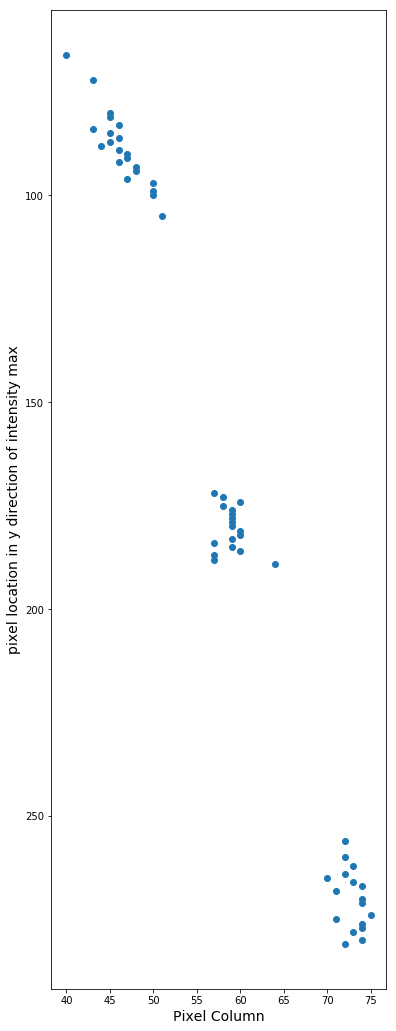

In [2572]:
plt.figure(figsize=(6,18))
plt.scatter(vernanargmax,X)
plt.ylabel("pixel location in y direction of intensity max",size=14)
plt.xlabel("Pixel Column",size=14)
#plt.scatter(np.linspace(0,60,60),horargmax[60:120])

ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1]) 


In [2573]:
#w1r=(60,140)
#x1r=(30,90)
#x2r=(250,300)

x1r=(50,100)
x2r=(270,290)


verwing1 = np.polyfit(X[x1r[0]:x1r[1]], verargmax[x1r[0]:x1r[1]], 1)
print(verwing1)

verwing2 = np.polyfit(X[x2r[0]:x2r[1]], verargmax[x2r[0]:x2r[1]], 1)
print(verwing2)

[-3.66386555e-02  4.81895798e+01]
[  0.30526316 -10.92105263]


In [2574]:
Y1=range(x1r[0],x1r[1],1)
print(Y1)

range(50, 100)


In [2575]:
gverwing1 = []

Y1=range(x1r[0],x1r[1],1)

for i in Y1:
    whichcol = i
    data=subvim[whichcol,:]
    y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
    
    x=np.arange(rows)
    
    H, A, x0, stddev = gauss_fit(0,x, y)
    
    gverwing1.append(A)
    
gverwing1=np.array(gverwing1)

gverwing2 = []

Y2=range(x2r[0],x2r[1],1)

for i in Y2:
    whichcol = i
    data=subvim[whichcol,:]
    y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
    
    x=np.arange(rows)
    
    H, A, x0, stddev = gauss_fit(0.1,x, y)
    
    gverwing2.append(A)
    
gverwing2=np.array(gverwing2)



In [2576]:
print(gverwing1)
#ghorwing2.shape

[35.69291674 38.56057792 38.45930695 37.9154873  36.63261067 37.32741685
 38.02014698 39.16289098 39.00324265 41.12854721 62.34559887 39.79416311
 39.96476654 41.73598036 38.6993035  40.19179274 40.12905512 39.72964938
 41.44920719 41.87636782 41.59028704 41.99099461 42.02651935 41.82496299
 41.85686248 41.9203144  42.95179656 42.43797645 43.52615103 44.22165666
 43.58377854 44.05487953 44.75694055 44.34745967 44.76393132 45.24790099
 45.42578588 45.22384126 45.78994912 46.42668882 46.78122952 46.97617012
 46.97515381 46.66012192 47.61825902 48.07739102 49.13462133 49.72638504
 48.17284995 49.03367541]


In [2577]:
gausvwing1 = np.polyfit(Y1, gverwing1, 1)
gv1 = np.poly1d(gausvwing1)
gausvwing2 = np.polyfit(Y2, gverwing2, 1)
gv2 = np.poly1d(gausvwing2)

(301.1236941452463, 38.038516871296935)

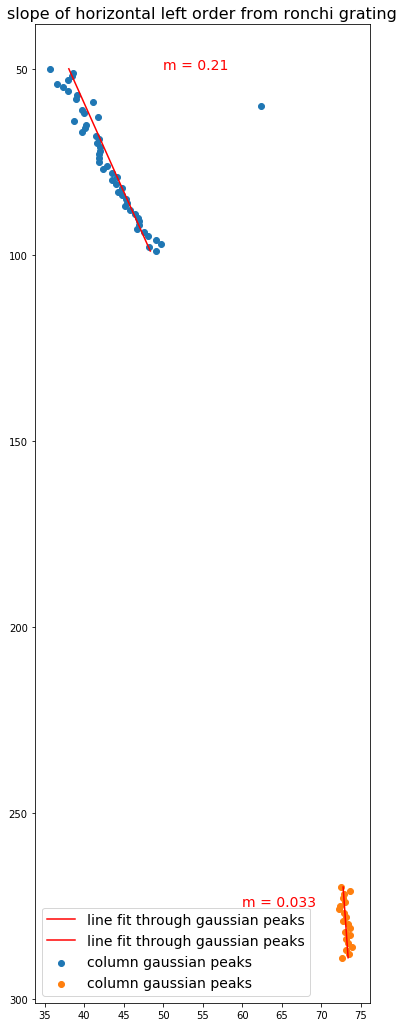

In [2578]:
m_hdiff=str(abs(round(gausvwing2[0]-gausvwing1[0],3)))

fig,ax = plt.subplots()

fig.set_size_inches(6, 18)

ax.scatter(gverwing1, Y1, label="column gaussian peaks")
ax.plot(gv1(Y1),Y1,color='red',label="line fit through gaussian peaks")
ax.scatter(gverwing2, Y2, label="column gaussian peaks")
ax.plot(gv2(Y2),Y2,color='red',label="line fit through gaussian peaks")
ax.text(50,50,'m = ' + str(round(gausvwing1[0],3)),fontsize=14,color='red')
ax.text(60,275,'m = ' + str(round(gausvwing2[0],3)),fontsize=14,color='red')
#ax.text(150,20,'diff between hor wings = ' + m_hdiff,fontsize=14,color='red')
ax.legend(fontsize=14)
ax.set_title("slope of horizontal left order from ronchi grating",fontsize=16)

ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1]) 


In [2579]:
gaushwing1

array([-0.12578363, 85.14268282])

In [2580]:
gaushwing2

array([-0.13880342, 84.86981747])

In [2581]:
gausvwing1

array([ 0.21020988, 27.55823548])

In [2582]:
gausvwing2

array([3.32812969e-02, 6.37635865e+01])

### Increase contrast

In [2583]:
imarray3=np.cbrt(imarray)/(np.max(imarray))

### Solver

In [2584]:
Ah = np.array([[ -gaushwing1[0],1], [-gaushwing2[0],1] ])
bh = np.array([gaushwing1[1],gaushwing2[1]])
zh = np.linalg.solve(Ah,bh)
#print(zh)

Av = np.array([[1, -gausvwing1[0]], [1,-gausvwing2[0]] ])
bv = np.array([gausvwing1[1],gausvwing2[1]])
zv = np.linalg.solve(Av,bv)
#print(zv)

horsecx=zh[0]+int(sx)-bdl
horsecy=zh[1]+int(sy)-bds

versecx=zv[0]+int(sx)-bds
versecy=zv[1]+int(sy)-bdl

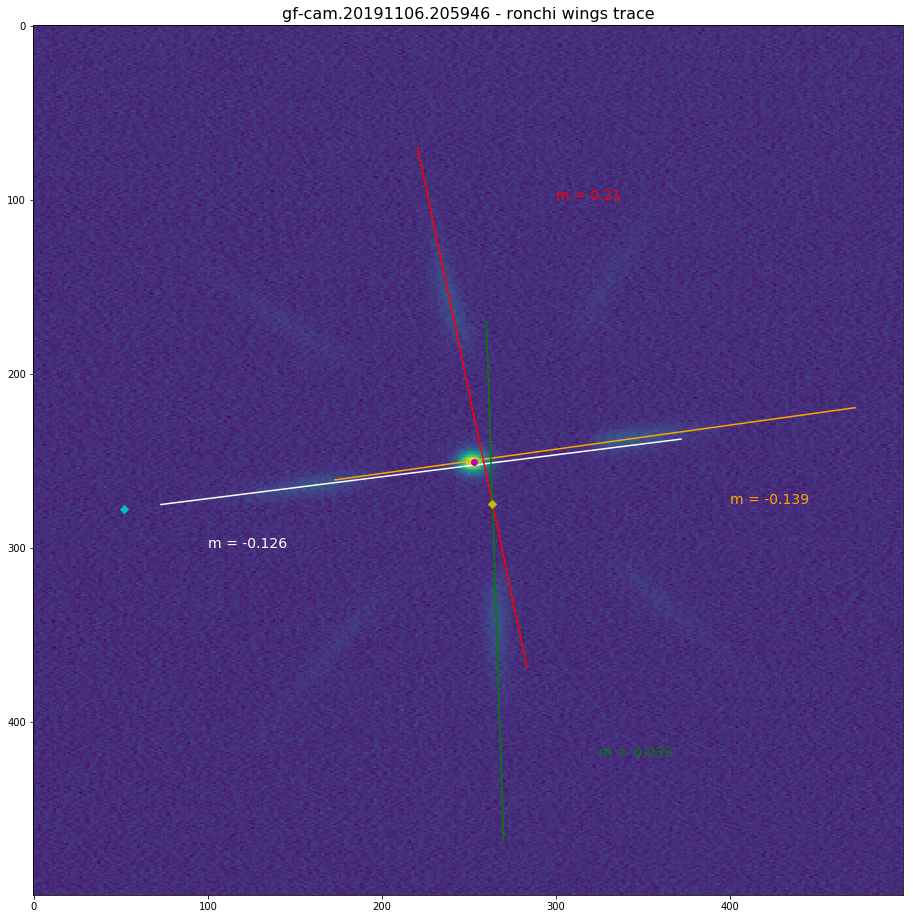

In [2585]:
ff=np.arange(0,300,1)
ff2=np.arange(100,400,1)
ff3=np.arange(0,300,1)
ff4=np.arange(100,400,1)

fig,ax = plt.subplots()

fig.set_size_inches(16, 16)
ax.imshow(imarray3,origin='lower')
#ax.imshow(imarray)

ax.plot(ff+int(sx)-bdl,gh1(ff)+int(sy)-bds,color='white')
ax.text(100,300,'m = ' + str(round(gaushwing1[0],3)),fontsize=14,color='white')
ax.plot(ff2+int(sx)-bdl,gh2(ff2)+int(sy)-bds,color='orange')
ax.text(400,275,'m = ' + str(round(gaushwing2[0],3)),fontsize=14,color='orange')
ax.plot(gv1(ff3)+int(sx)-bds,ff3+int(sy)-bdl,color='red')
ax.text(300,100,'m = ' + str(round(gausvwing1[0],3)),fontsize=14,color='red')
ax.plot(gv2(ff4)+int(sx)-bds,ff4+int(sy)-bdl,color='green')
ax.text(325,420,'m = ' + str(round(gausvwing2[0],3)),fontsize=14,color='green')
ax.set_title(filename + " - ronchi wings trace",fontsize=16)
ax.plot(sx,sy,'mo')
ax.plot(horsecx,horsecy,'cD')
ax.plot(versecx,versecy,'yD')


ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1]) 

fig.savefig(filename + 'ronchi-wing-trace.png')